In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle

file_name = 'fxReynoldsV3.xlsx'
file_path = os.path.join(os.getcwd(), file_name)

ANNDF = pd.read_excel(file_path)

X = ANNDF.iloc[:, [1, 3]].values
Y = ANNDF.iloc[:, 2].values.reshape(-1, 1)

X, Y = shuffle(X, Y)

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, train_size=0.75)  # 30% for testing and shuffle

scalerx = StandardScaler()
scalery = StandardScaler()

Xtrain = scalerx.fit_transform(xtrain)
Ytrain = scalery.fit_transform(ytrain)

mlp = MLPRegressor(max_iter=5000)

nneurons = [1, 2, 4, 8, 16, 32, 64, 128]
parameters = {'hidden_layer_sizes': [],
              'activation': ['relu', 'tanh', 'logistic'],
              'solver': ['adam']
}

for n in nneurons:
    parameters['hidden_layer_sizes'].append((n,))

for n1 in nneurons:
    for n2 in nneurons:
        parameters['hidden_layer_sizes'].append((n1, n2))

kf = KFold(n_splits=10, shuffle=True)

gsearchcv = GridSearchCV(estimator=mlp, param_grid=parameters, cv=kf, verbose=2)
gsearchcv.fit(Xtrain, Ytrain.ravel())

bestac = gsearchcv.best_score_ * 100  # Convert to percentage
bestparam = gsearchcv.best_params_

print('Best Accuracy: {:.2f} %'.format(bestac))
print('Best Parameters:', bestparam)

Xtest_scaled = scalerx.transform(xtest)
ypred = gsearchcv.predict(Xtest_scaled).reshape(-1, 1)
ypred_or = scalery.inverse_transform(ypred)

r2 = r2_score(ytest, ypred_or)
rmse = mean_squared_error(ytest, ypred_or, squared=False)

r2, rmse

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.7s
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.4s
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(2,), solver=adam; total time=   0.4s
[CV] END activation=re

(0.9776357385800817, 0.017831948762980908)

In [ ]:
print()

In [2]:
def cor1(Re):
    f = 2.344 * np.power(Re,-0.081) #correlação kaixin yan  300 < RE <3100
    return f

def cor2(Re):
    f = 2.765 * np.power(Re,-0.166) #correlação kaixin yan  300 < RE <3100
    return f

Recor1 = np.linspace(1000,3100,15)
stpkyan = [0.3745] * len(Recor1)

In [59]:
import numpy as np
import plotly.graph_objs as go
import plotly.offline as pyo



# Definir os intervalos para Re e Stdp
Re_vals = np.linspace(300, 10000, 100)  # Valores de Reynolds de 1000 a 8000
Stdp_vals = np.linspace(0.3326, 0.4331, 100)  # Valores de Stdp de 0.3326 a 0.4331

# Criar uma grade de Re e Stdp
Re_grid, Stdp_grid = np.meshgrid(Re_vals, Stdp_vals)
grid_points = np.c_[Re_grid.ravel(), Stdp_grid.ravel()]

# Prever os valores de 'f' usando a ANN nos pontos da grade
f_pred_scaled = gsearchcv.predict(scalerx.transform(grid_points))
f_pred = scalery.inverse_transform(f_pred_scaled.reshape(-1, 1))
f_pred_grid = f_pred.reshape(Re_grid.shape)

# Calcular a superfície usando a fórmula fornecida
#f_formula = 2.9728 + -6.0736e-05*Re_grid + -10.097*Stdp_grid + 5.0583e-09*Re_grid**2 + -4.1042e-05*Re_grid * Stdp_grid + 11.001*Stdp_grid**2

# Criar o gráfico 3D para os resultados da ANN com contornos
surface_ann = go.Surface(
    x=Re_grid, y=Stdp_grid, z=f_pred_grid, 
    colorscale='Viridis',
    name='Superfície ANN',
    colorbar=dict(title='ANN f', len=0.5, x=0.9),
    contours={
        "z": {
            "show": True,
            "start": np.min(f_pred_grid),
            "end": np.max(f_pred_grid),
            "size": (np.max(f_pred_grid) - np.min(f_pred_grid)) / 20,  # Ajustar o espaçamento dos contornos
            "color": "black",
        }
    }
)

# Criar o gráfico 3D para a fórmula fornecida com contornos
'''surface_formula = go.Surface(
    x=Re_grid, y=Stdp_grid, z=f_formula, 
    colorscale='Plasma',
    name='Superfície Fórmula',
    opacity=0.7,
    colorbar=dict(title='Fórmula f', len=0.5, x=1.05),
    contours={
        "z": {
            "show": True,
            "start": np.min(f_formula),
            "end": np.max(f_formula),
            "size": (np.max(f_formula) - np.min(f_formula)) / 20,
            "color": "black",
        }
    }
)'''

# Scatter plot dos valores originais
scatter_cor = go.Scatter3d(
    x=Recor1,  # Valores de Reynolds
    y=stpkyan,  # Valores de Stdp
    z=cor2(Recor1),  # Valores de 'f'
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Valores Originais'
)


# Scatter plot dos valores originais
scatter_data = go.Scatter3d(
    x=ANNDF.iloc[:, 0].values,  # Valores de Reynolds
    y=ANNDF.iloc[:, 2].values,  # Valores de Stdp
    z=ANNDF.iloc[:, 1].values,  # Valores de 'f'
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Valores Originais'
)

# Definir o layout do gráfico
layout = go.Layout(
    title='Superfície de Resultados da ANN e da Fórmula com Valores Originais',
    scene=dict(
        xaxis=dict(title='Reynolds Number (Re)', backgroundcolor='white', gridcolor='lightgrey'),
        yaxis=dict(title='Stdp', backgroundcolor='white', gridcolor='lightgrey'),
        zaxis=dict(title='f', backgroundcolor='white', gridcolor='lightgrey'),
        bgcolor='white'
    ),
    paper_bgcolor='white',
    plot_bgcolor='white',
    showlegend=True
)

# Criar a figura com ambas as superfícies e o scatter plot
fig = go.Figure(data=[surface_ann ,surface_formula,scatter_cor], layout=layout)

# Mostrar o gráfico
pyo.plot(fig)


'temp-plot.html'

In [60]:
import numpy as np
import plotly.graph_objs as go
import plotly.offline as pyo

# Definir os intervalos para Re
Re_vals = np.linspace(300, 10000, 100)  # Valores de Reynolds de 300 a 10000

# Valores de Stdp fixos
stdp_values = [0.3326, 0.3745, 0.3996, 0.4152, 0.4331]

# Lista para armazenar as curvas
data = []

# Gerar as curvas para cada valor de Stdp
for stdp in stdp_values:
    # Criar pontos da grade fixando Stdp
    grid_points = np.c_[Re_vals, np.full_like(Re_vals, stdp)]
    
    # Prever os valores de 'f' usando a ANN nos pontos da grade
    f_pred_scaled = gsearchcv.predict(scalerx.transform(grid_points))
    f_pred = scalery.inverse_transform(f_pred_scaled.reshape(-1, 1)).ravel()
    
    # Criar o scatter plot para cada valor de Stdp
    trace = go.Scatter(
        x=Re_vals,
        y=f_pred,
        mode='lines',
        name=f'Stdp = {stdp:.4f}'
    )
    data.append(trace)

# Definir o layout do gráfico
layout = go.Layout(
    title='Reynolds Number (Re) vs. f para diferentes valores de Stdp',
    xaxis=dict(title='Reynolds Number (Re)', gridcolor='lightgrey'),
    yaxis=dict(title='f', gridcolor='lightgrey'),
    paper_bgcolor='white',
    plot_bgcolor='white',
    showlegend=True
)

# Criar a figura com todas as curvas
fig = go.Figure(data=data, layout=layout)

# Mostrar o gráfico
pyo.plot(fig)


'temp-plot.html'

In [58]:
import numpy as np
import plotly.graph_objs as go
import plotly.offline as pyo



# Definir os intervalos para Re e Stdp
Re_vals = np.linspace(200, 8000, 100)  # Valores de Reynolds de 1000 a 8000
Stdp_vals = np.linspace(0.2992, 0.4331, 100)  # Valores de Stdp de 0.3326 a 0.4331

#ffc = 2.7753 + (-3.1833e-04)*Re_vals + (-7.3509e+00)*Stdp_vals + (1.1566e-08)*Re_vals^2 + (9.1489e-04)*Re_vals * Stdp_vals + (3.0968e+00)*Stdp_vals^2 + (-5.4668e-13)*Re_vals^3 + (-2.9617e-09)*Re_vals^2 * Stdp_vals + (-7.7045e-04)*Re_vals * Stdp_vals^2 + (6.7924e+00)*Stdp_vals^3



# Criar uma grade de Re e Stdp
Re_grid, Stdp_grid = np.meshgrid(Re_vals, Stdp_vals)
grid_points = np.c_[Re_grid.ravel(), Stdp_grid.ravel()]

# Prever os valores de 'f' usando a ANN nos pontos da grade
f_pred_scaled = gsearchcv.predict(scalerx.transform(grid_points))
f_pred = scalery.inverse_transform(f_pred_scaled.reshape(-1, 1))
f_pred_grid = f_pred.reshape(Re_grid.shape)

# Calcular a superfície usando a fórmula fornecida
f_formula = 

# Criar o gráfico 3D para os resultados da ANN com contornos
surface_ann = go.Surface(
    x=Re_grid, y=Stdp_grid, z=f_pred_grid, 
    colorscale='Viridis',
    name='Superfície ANN',
    colorbar=dict(title='ANN f', len=0.5, x=0.9),
    contours={
        "z": {
            "show": True,
            "start": np.min(f_pred_grid),
            "end": np.max(f_pred_grid),
            "size": (np.max(f_pred_grid) - np.min(f_pred_grid)) / 20,  # Ajustar o espaçamento dos contornos
            "color": "black",
        }
    }
)

# Criar o gráfico 3D para a fórmula fornecida com contornos
surface_formula = go.Surface(
    x=Re_grid, y=Stdp_grid, z=f_formula, 
    colorscale='Plasma',
    name='Superfície Fórmula',
    opacity=0.7,
    colorbar=dict(title='Fórmula f', len=0.5, x=1.05),
    contours={
        "z": {
            "show": True,
            "start": np.min(f_formula),
            "end": np.max(f_formula),
            "size": (np.max(f_formula) - np.min(f_formula)) / 20,
            "color": "black",
        }
    }
)

# Scatter plot dos valores originais
scatter_cor = go.Scatter3d(
    x=Recor1,  # Valores de Reynolds
    y=stpkyan,  # Valores de Stdp
    z=cor2(Recor1),  # Valores de 'f'
    mode='markers',
    marker=dict(size=5, color='black'),
    name='Kaixin Yan et. al (Polished)'
)

scatter_cor2 = go.Scatter3d(
    x=xtest[:,0],  # Valores de Reynolds
    y=xtest[:,1],  # Valores de Stdp
    z=ypred_or.flatten(),  # Valores de 'f'
    mode='markers',
    marker=dict(size=5, color='red', symbol = 'diamond'),
    name='Predict / Validation'
)



# Scatter plot dos valores originais
scatter_data = go.Scatter3d(
    x=ANNDF.iloc[:, 0].values,  # Valores de Reynolds
    y=ANNDF.iloc[:, 2].values,  # Valores de Stdp
    z=ANNDF.iloc[:, 1].values,  # Valores de 'f'
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Valores Originais'
)

# Definir o layout do gráfico
layout = go.Layout(
    title='Superfície de Resultados da ANN e da Fórmula com Valores Originais',
    scene=dict(
        xaxis=dict(title='Reynolds Number (Re)', backgroundcolor='white', gridcolor='lightgrey'),
        yaxis=dict(title='Stdp', backgroundcolor='white', gridcolor='lightgrey'),
        zaxis=dict(title='f', backgroundcolor='white', gridcolor='lightgrey'),
        bgcolor='white'
    ),
    paper_bgcolor='white',
    plot_bgcolor='white',
    showlegend=True
)

# Criar a figura com ambas as superfícies e o scatter plot
fig = go.Figure(data=[surface_ann, surface_formula], layout=layout)

# Mostrar o gráfico
pyo.plot(fig)


'temp-plot.html'

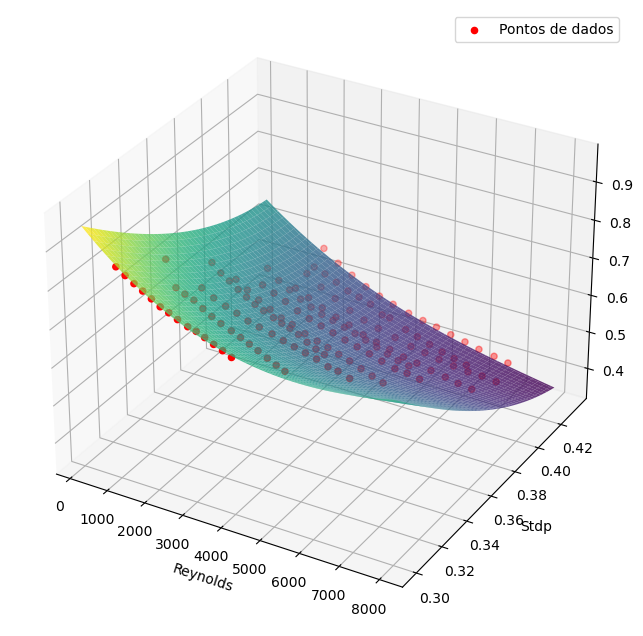

Expressão da regressão:
f = 1.8906 + -0.00017828*Re + 0.018425*Stdp + 2.0488e-08*Re^2 + 0.0003242*Re Stdp + -18.674*Stdp^2 + -3.1231e-13*Re^3 + -2.9643e-08*Re^2 Stdp + -0.00022423*Re Stdp^2 + 27.991*Stdp^3


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits.mplot3d import Axes3D

# Carrega os dados
file_name = 'fxReynoldsV3.xlsx'
file_path = os.path.join(os.getcwd(), file_name)
ANNDF = pd.read_excel(file_path)

# Extrai as variáveis
# Supondo que:
# Coluna 1: Reynolds
# Coluna 2: f
# Coluna 3: Stdp
X = ANNDF.iloc[:, [1, 3]].values  # Reynolds e Stdp
Y = ANNDF.iloc[:, 2].values  # f

# Cria uma grade de valores para Reynolds e Stdp
Re_range = np.linspace(200, 8000, 100)
Stdp_range = np.linspace(0.2992, 0.4331, 100)
Re_mesh, Stdp_mesh = np.meshgrid(Re_range, Stdp_range)

# Achata a grade para predição
Re_flat = Re_mesh.flatten()
Stdp_flat = Stdp_mesh.flatten()
X_grid = np.column_stack((Re_flat, Stdp_flat))

# Realiza a regressão polinomial nos dados originais
degree = 2  # Você pode ajustar o grau conforme necessário
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, Y)

# Prediz os valores de f sobre a grade
X_grid_poly = poly.transform(X_grid)
f_pred = model.predict(X_grid_poly)
f_mesh = f_pred.reshape(Re_mesh.shape)

# Plota a superfície
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Re_mesh, Stdp_mesh, f_mesh, cmap='viridis', alpha=0.8)
ax.scatter(X[:, 0], X[:, 1], Y, color='red', s=20, label='Pontos de dados')
ax.set_xlabel('Reynolds')
ax.set_ylabel('Stdp')
ax.set_zlabel('f')
ax.legend()
plt.show()

# Extrai os coeficientes da regressão
coefficients = model.coef_
intercept = model.intercept_
feature_names = poly.get_feature_names_out(['Re', 'Stdp'])

# Constrói a expressão da regressão
terms = [f"{coef:.5g}*{name}" for coef, name in zip(coefficients, feature_names)]
expression = f"f = {intercept:.5g} + " + " + ".join(terms[1:])  # Exclui o termo intercepto duplicado

print("Expressão da regressão:")
print(expression)
